In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from tensorflow.keras.datasets import cifar10
import random

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
x_train.shape

(50000, 32, 32, 3)

In [0]:
x_test.shape

(10000, 32, 32, 3)

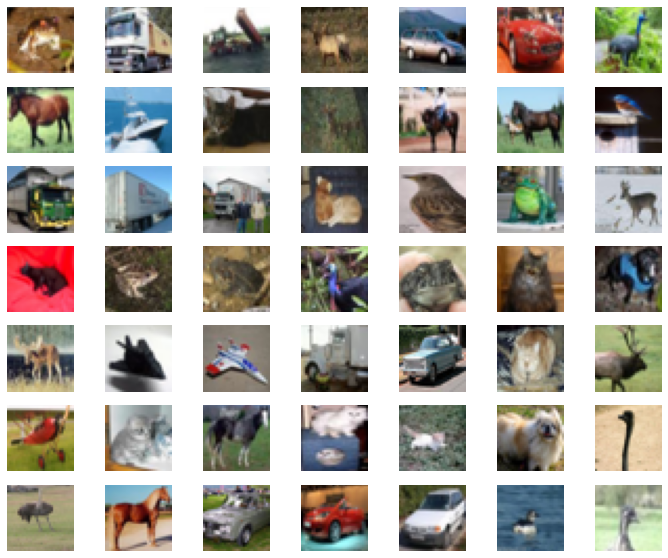

In [0]:
plt.figure(figsize = (12,10))
for i in range(49):
    plt.subplot(7,7,i+1)
    plt.axis("off")
    plt.imshow(x_train[i])

In [0]:
def discriminator(input_shape = (32,32,3)):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size = 3, padding="same", input_shape = input_shape),
        tf.keras.layers.LeakyReLU(alpha = 0.2),
        tf.keras.layers.Conv2D(128, (3,3), strides = (2,2), padding="same"),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Conv2D(128, (3,3), strides = (2,2), padding="same"),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Conv2D(256, (3,3), strides = (2,2), padding="same"),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, "sigmoid")
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["acc"])
    return model

In [0]:
d_model = discriminator()

In [0]:
d_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

In [0]:
def load_real_samples():
    (x_train, _), (_,_) = cifar10.load_data()
    x_train = x_train.astype("float32")
    x_train = (x_train - 127.5)/127.5
    return x_train

In [0]:
def generate_real_batch_samples(dataset, n_samples):
    nos = random.sample(range(len(dataset)), n_samples)
    samples = dataset[nos]
    y = np.ones((n_samples), dtype = int)
    return samples,y

In [0]:
def generate_fake_examples(n_samples):
    rand_samp = np.random.uniform(size = 32 * 32 * 3 * n_samples)
    rand_samp = -1 + rand_samp * 2
    X = np.reshape(rand_samp, (n_samples, 32, 32, 3))
    y = np.zeros(shape = (n_samples,1))
    return X,y

In [0]:
def train_discriminator(model, dataset, num_iterations = 20, n_batch = 128):
    half_batch = int(n_batch/2)
    for i in range(num_iterations):
        X_real, y_real = generate_real_batch_samples(dataset, half_batch)
        _, real_acc = model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_examples(half_batch)
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        print("Batch {}: Real acc: {} and Fake acc: {}".format(i+1, real_acc*100, fake_acc* 100))

In [0]:
model = discriminator()

In [0]:
dataset = load_real_samples()

In [0]:
train_discriminator(model, dataset)

Batch 1: Real acc: 39.0625 and Fake acc: 4.6875
Batch 2: Real acc: 98.4375 and Fake acc: 9.375
Batch 3: Real acc: 93.75 and Fake acc: 35.9375
Batch 4: Real acc: 93.75 and Fake acc: 59.375
Batch 5: Real acc: 89.0625 and Fake acc: 95.3125
Batch 6: Real acc: 90.625 and Fake acc: 100.0
Batch 7: Real acc: 89.0625 and Fake acc: 100.0
Batch 8: Real acc: 87.5 and Fake acc: 100.0
Batch 9: Real acc: 82.8125 and Fake acc: 100.0
Batch 10: Real acc: 87.5 and Fake acc: 100.0
Batch 11: Real acc: 92.1875 and Fake acc: 100.0
Batch 12: Real acc: 93.75 and Fake acc: 100.0
Batch 13: Real acc: 96.875 and Fake acc: 100.0
Batch 14: Real acc: 98.4375 and Fake acc: 100.0
Batch 15: Real acc: 96.875 and Fake acc: 100.0
Batch 16: Real acc: 95.3125 and Fake acc: 100.0
Batch 17: Real acc: 100.0 and Fake acc: 100.0
Batch 18: Real acc: 100.0 and Fake acc: 100.0
Batch 19: Real acc: 100.0 and Fake acc: 100.0
Batch 20: Real acc: 98.4375 and Fake acc: 100.0


In [0]:
def generator(latent_dim):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256 * 4 * 4, input_dim = latent_dim),
        tf.keras.layers.LeakyReLU(0.02),
        tf.keras.layers.Reshape((4,4,256)),
        tf.keras.layers.Conv2DTranspose(128, 4, strides = (2,2), padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(0.2),
        
        tf.keras.layers.Conv2DTranspose(128, 4, strides = (2,2), padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(0.2),
        
        tf.keras.layers.Conv2DTranspose(128, 3, strides = (2,2), padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(0.2),
        
        tf.keras.layers.Conv2D(3, (3,3), padding="same", activation='tanh')
        ])
    return model

In [0]:
g_model = generator(100)

In [0]:
g_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)      

In [0]:
def generate_latent_space(latent_dim, n_samples):
    x = np.random.randn(latent_dim * n_samples)
    x = np.reshape(x, (n_samples, latent_dim))
    return x

In [0]:
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_space(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

In [0]:
init_preds = generate_fake_samples(g_model, 100, 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

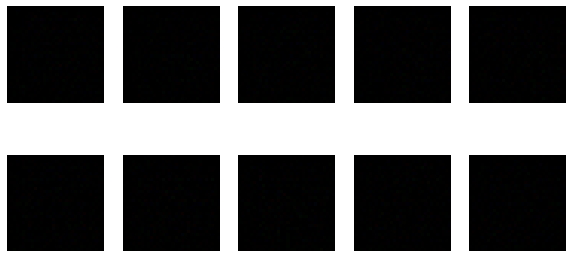

In [0]:
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(init_preds[0][i])
    plt.axis("off")

In [0]:
def gan(g_model, d_model):
    d_model.trainable = False
    model = tf.keras.models.Sequential([
        g_model,
        d_model
    ])
    optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
    model.compile(optimizer = optimizer, loss = "binary_crossentropy")
    return model

In [0]:
gan_model = gan(g_model, d_model)

In [47]:
gan_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_18 (Sequential)   (None, 32, 32, 3)         1352963   
_________________________________________________________________
sequential_17 (Sequential)   (None, 1)                 522497    
Total params: 1,875,460
Trainable params: 1,352,195
Non-trainable params: 523,265
_________________________________________________________________


In [0]:
def train_gan(model, latent_dim, epochs, n_batch):
    for i in range(epochs):
        x_gan = generate_latent_space(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1))
        model.train_on_batch(x_gan, y_gan)

In [0]:
def train( g_model, d_model,dataset, gan_model,  latent_dim, epochs = 200, n_batch = 128):
    batch_per_epoch = int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    for i in range(epochs):
        for j in range(batch_per_epoch):
            X_real, y_real = generate_real_batch_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_space(latent_dim, n_batch)
            y_gan = np.ones(shape = (n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            if(j%50 == 0):
              print("Epoch {} >> Batch{} >> Batch_per_epoch {} >> D_Loss_1 = {} >> D_loss_2 = {} >> g_loss = {}".format(i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
        if ((i+1)%10 == 0):
          summarize_performance(i, g_model, d_model, dataset, latent_dim)
    

In [0]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples = 150):
    x_real, y_real = generate_real_batch_samples(dataset, n_samples)
    _, acc = d_model.evaluate(x_real, y_real)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, accf = d_model.evaluate(x_fake, y_fake)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc*100, accf*100))
    save_plot(x_fake, epoch)

In [0]:
def save_plot(examples, epoch, n=7):
    examples = (examples + 1)/2.0
    plt.figure(figsize = (12,8))
    for i in range(n*n):
        plt.subplot(n,n,i+1)
        plt.axis("off")
        plt.imshow(examples[i])
    plt.show()

In [0]:
latent_dim = 100
# create the discriminator
d_model = discriminator()
# create the generator
g_model =generator(latent_dim)
# create the gan
gan_model = gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model

In [70]:
 int(dataset.shape[0] / 64)

781

Epoch 1 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.523786187171936 >> D_loss_2 = 0.028484735637903214 >> g_loss = 1.2464882135391235
Epoch 1 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.039321158081293106 >> D_loss_2 = 0.027485201135277748 >> g_loss = 0.22795073688030243
Epoch 1 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 0.013386215083301067 >> D_loss_2 = 0.01634305715560913 >> g_loss = 0.13380971550941467
Epoch 1 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.05138370767235756 >> D_loss_2 = 0.006486072205007076 >> g_loss = 0.01319913100451231
Epoch 1 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 0.1388111710548401 >> D_loss_2 = 0.03180243447422981 >> g_loss = 1.14441978931427
Epoch 1 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.22863754630088806 >> D_loss_2 = 0.12125373631715775 >> g_loss = 0.7835770845413208
Epoch 1 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 0.12224851548671722 >> D_loss_2 = 0.1867658793926239 >> g_loss = 0.884443998336792
Epoch 1 

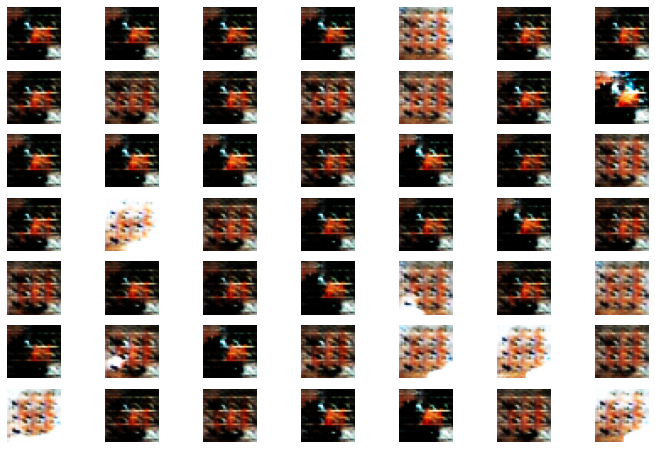

Epoch 11 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.014588196761906147 >> D_loss_2 = 0.01681005023419857 >> g_loss = 1.490563988685608
Epoch 11 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.24716350436210632 >> D_loss_2 = 0.022936947643756866 >> g_loss = 0.9190929532051086
Epoch 11 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 0.08430865406990051 >> D_loss_2 = 0.02048470452427864 >> g_loss = 0.04927974194288254
Epoch 11 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0036861600819975138 >> D_loss_2 = 0.01165734976530075 >> g_loss = 0.19417712092399597
Epoch 11 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 0.003059425624087453 >> D_loss_2 = 0.001428739633411169 >> g_loss = 0.20300719141960144
Epoch 11 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.3040392994880676 >> D_loss_2 = 0.13455188274383545 >> g_loss = 2.1200428009033203
Epoch 11 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 0.11305058002471924 >> D_loss_2 = 0.027809198945760727 >> g_loss = 0.44275730848

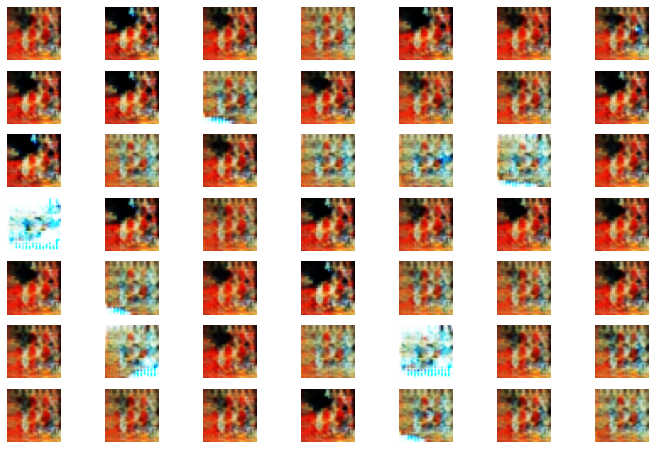

Epoch 21 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.02002747170627117 >> D_loss_2 = 0.013449111953377724 >> g_loss = 0.6108578443527222
Epoch 21 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0005285447696223855 >> D_loss_2 = 0.0014008128782734275 >> g_loss = 0.08289479464292526
Epoch 21 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 6.838601257186383e-05 >> D_loss_2 = 0.058906253427267075 >> g_loss = 3.388395309448242
Epoch 21 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 3.563427162589505e-05 >> D_loss_2 = 0.0007227320456877351 >> g_loss = 0.03891165927052498
Epoch 21 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 0.029010502621531487 >> D_loss_2 = 0.006633376702666283 >> g_loss = 0.19792410731315613
Epoch 21 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.09781542420387268 >> D_loss_2 = 0.057866230607032776 >> g_loss = 0.14109814167022705
Epoch 21 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0013335533440113068 >> D_loss_2 = 0.004399359226226807 >> g_loss = 

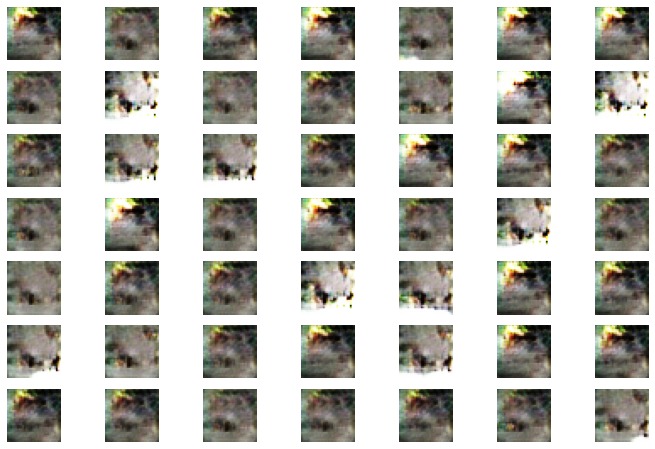

Epoch 31 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.018232019618153572 >> D_loss_2 = 0.019018176943063736 >> g_loss = 1.397660732269287
Epoch 31 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.017724664881825447 >> D_loss_2 = 0.05671919882297516 >> g_loss = 3.283491849899292
Epoch 31 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 0.008297632448375225 >> D_loss_2 = 0.024645324796438217 >> g_loss = 0.26032572984695435
Epoch 31 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.021955549716949463 >> D_loss_2 = 0.013824702240526676 >> g_loss = 0.07454931735992432
Epoch 31 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 0.07327486574649811 >> D_loss_2 = 0.02106579765677452 >> g_loss = 1.2605924606323242
Epoch 31 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.022082669660449028 >> D_loss_2 = 0.020561596378684044 >> g_loss = 0.19383995234966278
Epoch 31 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 0.003001684322953224 >> D_loss_2 = 0.05141621083021164 >> g_loss = 1.35667276

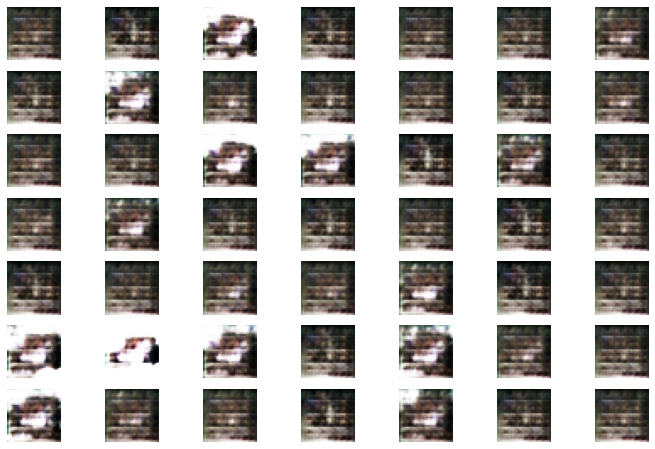

Epoch 41 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.04761001840233803 >> D_loss_2 = 0.01750711165368557 >> g_loss = 1.0657273530960083
Epoch 41 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0021812589839100838 >> D_loss_2 = 0.016228195279836655 >> g_loss = 0.6553106307983398
Epoch 41 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 0.031072616577148438 >> D_loss_2 = 0.008734302595257759 >> g_loss = 0.6689273715019226
Epoch 41 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.070911705493927 >> D_loss_2 = 0.011057950556278229 >> g_loss = 0.3850076198577881
Epoch 41 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 3.969504177803174e-05 >> D_loss_2 = 0.004535785876214504 >> g_loss = 0.5553044676780701
Epoch 41 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 5.203591354074888e-05 >> D_loss_2 = 0.0008258494199253619 >> g_loss = 0.011742216534912586
Epoch 41 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 0.16452452540397644 >> D_loss_2 = 4.739175796508789 >> g_loss = 21.1973972

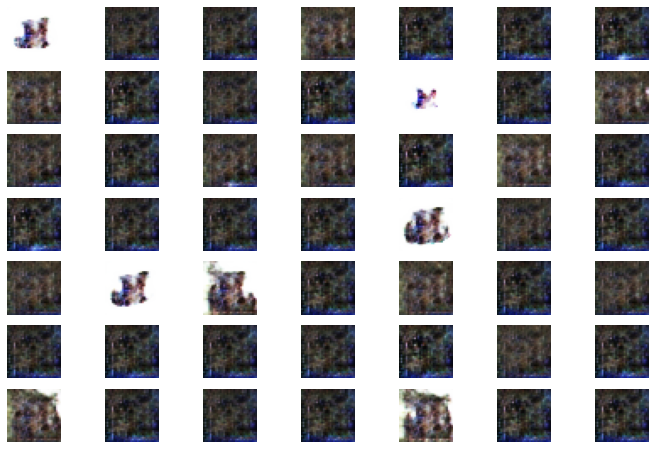

Epoch 51 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.07904066890478134 >> D_loss_2 = 0.10777634382247925 >> g_loss = 0.3201640248298645
Epoch 51 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.16416895389556885 >> D_loss_2 = 0.11692690849304199 >> g_loss = 1.8144618272781372
Epoch 51 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 0.07383833825588226 >> D_loss_2 = 0.07315026223659515 >> g_loss = 0.8719671964645386
Epoch 51 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.06299226731061935 >> D_loss_2 = 0.23389360308647156 >> g_loss = 2.8927886486053467
Epoch 51 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 0.6450691819190979 >> D_loss_2 = 0.11981949210166931 >> g_loss = 2.89174747467041
Epoch 51 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0394146628677845 >> D_loss_2 = 0.02377421036362648 >> g_loss = 0.3168622851371765
Epoch 51 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 0.015491760335862637 >> D_loss_2 = 0.006701095961034298 >> g_loss = 0.6705899238586426
Epoc

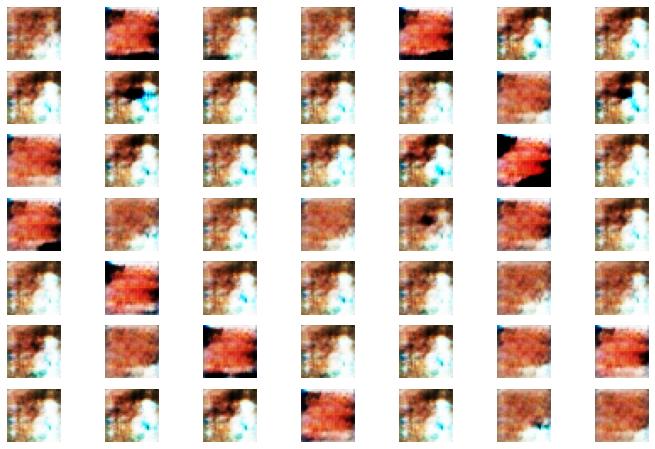

Epoch 61 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.10865228623151779 >> D_loss_2 = 0.29431501030921936 >> g_loss = 3.9142673015594482
Epoch 61 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.003824754850938916 >> D_loss_2 = 0.014368638396263123 >> g_loss = 2.2243306636810303
Epoch 61 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 0.09629505127668381 >> D_loss_2 = 0.0830143392086029 >> g_loss = 2.0465190410614014
Epoch 61 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.021954679861664772 >> D_loss_2 = 0.02813991717994213 >> g_loss = 0.21257653832435608
Epoch 61 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 0.09552159160375595 >> D_loss_2 = 0.01952679455280304 >> g_loss = 0.2951391935348511
Epoch 61 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.10507284104824066 >> D_loss_2 = 0.022972218692302704 >> g_loss = 0.2366810142993927
Epoch 61 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0517992302775383 >> D_loss_2 = 0.032475508749485016 >> g_loss = 1.951888203620910

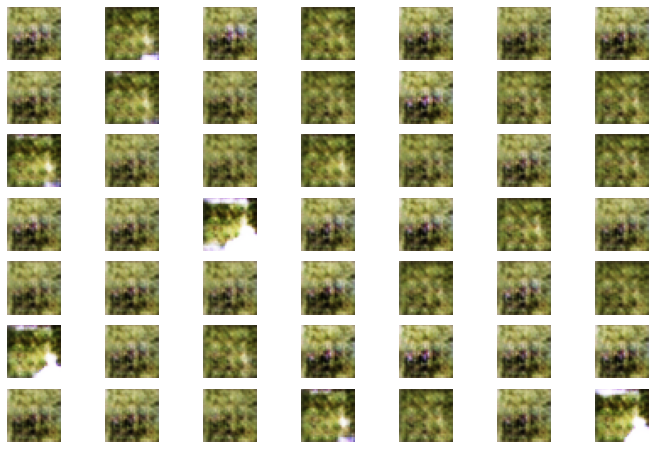

Epoch 71 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.061144910752773285 >> D_loss_2 = 0.10213321447372437 >> g_loss = 0.874626636505127
Epoch 71 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0067190369591116905 >> D_loss_2 = 0.10321363061666489 >> g_loss = 2.323322296142578
Epoch 71 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 0.042584195733070374 >> D_loss_2 = 0.0068712434731423855 >> g_loss = 0.6683364510536194
Epoch 71 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.23076407611370087 >> D_loss_2 = 0.038986437022686005 >> g_loss = 0.2531121075153351
Epoch 71 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0024564259219914675 >> D_loss_2 = 0.021608605980873108 >> g_loss = 0.15107807517051697
Epoch 71 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.06823086738586426 >> D_loss_2 = 0.03992903232574463 >> g_loss = 0.6899633407592773
Epoch 71 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 0.2532275915145874 >> D_loss_2 = 0.06211808696389198 >> g_loss = 5.95790195465

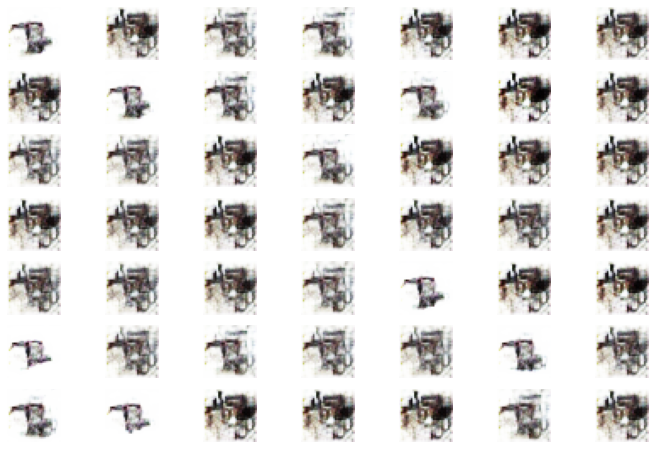

Epoch 81 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.02304995432496071 >> D_loss_2 = 0.05893634259700775 >> g_loss = 4.207647323608398
Epoch 81 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.000546990311704576 >> D_loss_2 = 0.028088118880987167 >> g_loss = 0.6064175963401794
Epoch 81 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 0.002353594172745943 >> D_loss_2 = 0.013158861547708511 >> g_loss = 0.14790210127830505
Epoch 81 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.03487376868724823 >> D_loss_2 = 0.07002916187047958 >> g_loss = 1.1757415533065796
Epoch 81 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 0.04964688792824745 >> D_loss_2 = 0.02493920363485813 >> g_loss = 1.2958108186721802
Epoch 81 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.045806799083948135 >> D_loss_2 = 0.037272483110427856 >> g_loss = 0.593101441860199
Epoch 81 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 0.10601666569709778 >> D_loss_2 = 0.039199281483888626 >> g_loss = 0.2217258512973

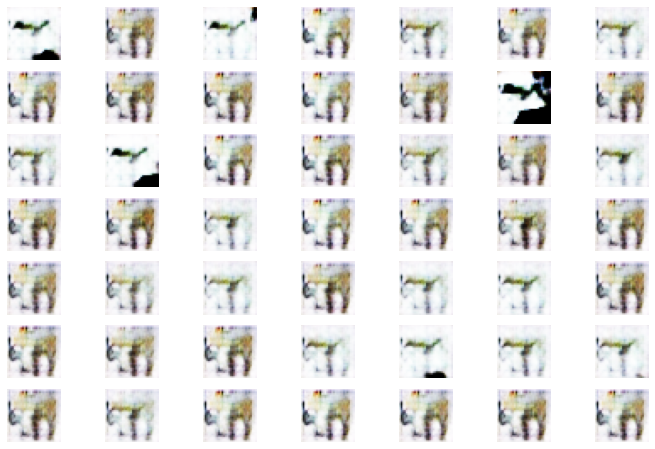

Epoch 91 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0007768868817947805 >> D_loss_2 = 8.23492810013704e-05 >> g_loss = 5.196088790893555
Epoch 91 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.006779820658266544 >> D_loss_2 = 0.006187992170453072 >> g_loss = 1.8204690217971802
Epoch 91 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 0.10241669416427612 >> D_loss_2 = 0.0362299308180809 >> g_loss = 2.388777017593384
Epoch 91 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.02486514113843441 >> D_loss_2 = 0.11356060206890106 >> g_loss = 0.6540011167526245
Epoch 91 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 1.6557574781472795e-05 >> D_loss_2 = 0.0013337398413568735 >> g_loss = 0.015994984656572342
Epoch 91 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.011656072922050953 >> D_loss_2 = 0.0077815004624426365 >> g_loss = 0.11394836753606796
Epoch 91 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0011357554467394948 >> D_loss_2 = 0.010161644779145718 >> g_loss = 0.064

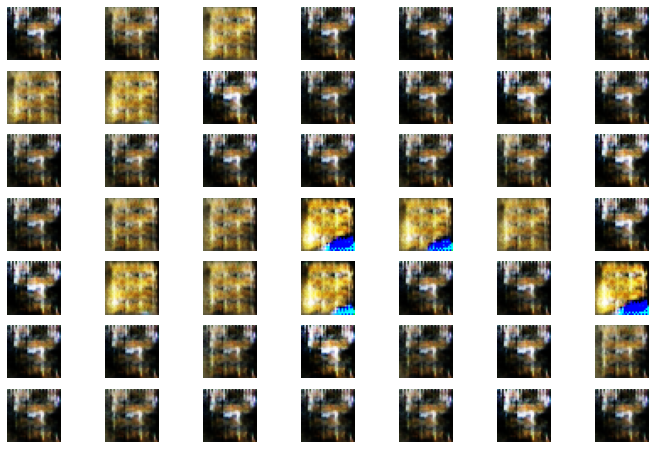

Epoch 101 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.013687935657799244 >> D_loss_2 = 0.006734352558851242 >> g_loss = 0.6605116128921509
Epoch 101 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.16532635688781738 >> D_loss_2 = 0.006754099391400814 >> g_loss = 5.117588996887207
Epoch 101 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 0.008426818065345287 >> D_loss_2 = 0.03304462879896164 >> g_loss = 0.20576128363609314
Epoch 101 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.04618939012289047 >> D_loss_2 = 0.00618405919522047 >> g_loss = 0.1408199667930603
Epoch 101 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 0.023832648992538452 >> D_loss_2 = 0.004129122477024794 >> g_loss = 0.2241201549768448
Epoch 101 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.04552547261118889 >> D_loss_2 = 0.11929978430271149 >> g_loss = 0.09987694025039673
Epoch 101 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0028014369308948517 >> D_loss_2 = 0.005924173630774021 >> g_loss = 0.04

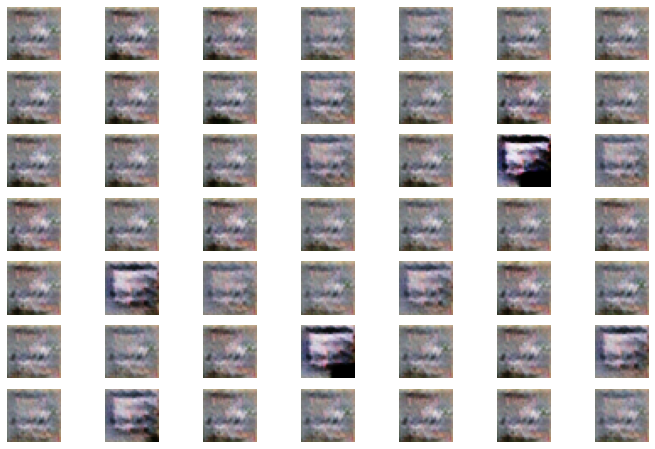

Epoch 111 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.22016587853431702 >> D_loss_2 = 0.435223788022995 >> g_loss = 2.6984004974365234
Epoch 111 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.03409614413976669 >> D_loss_2 = 0.0762980729341507 >> g_loss = 3.591437816619873
Epoch 111 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 2.9264139811857603e-05 >> D_loss_2 = 0.01392238400876522 >> g_loss = 0.29179370403289795
Epoch 111 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.08092077821493149 >> D_loss_2 = 0.0175296813249588 >> g_loss = 1.28322172164917
Epoch 111 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 0.13591891527175903 >> D_loss_2 = 0.0720587745308876 >> g_loss = 7.88822603225708
Epoch 111 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.17994184792041779 >> D_loss_2 = 0.025673719123005867 >> g_loss = 3.182713747024536
Epoch 111 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 0.29368171095848083 >> D_loss_2 = 0.02579740807414055 >> g_loss = 0.41162580251693726


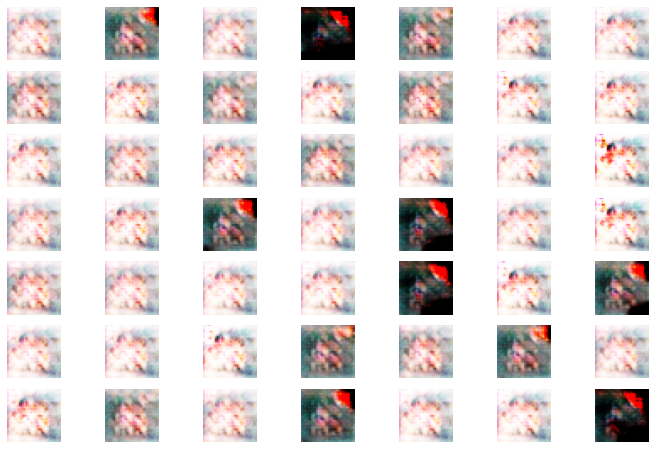

Epoch 121 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.004008302930742502 >> D_loss_2 = 0.00458306260406971 >> g_loss = 0.5745943188667297
Epoch 121 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.10436505824327469 >> D_loss_2 = 0.006647201254963875 >> g_loss = 2.1860053539276123
Epoch 121 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 0.009046806022524834 >> D_loss_2 = 0.004106275737285614 >> g_loss = 0.17658811807632446
Epoch 121 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.00010803015902638435 >> D_loss_2 = 0.007574289571493864 >> g_loss = 0.3360615372657776
Epoch 121 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0008001858950592577 >> D_loss_2 = 0.003947352524846792 >> g_loss = 0.06995626538991928
Epoch 121 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.032631970942020416 >> D_loss_2 = 0.0013087012339383364 >> g_loss = 0.004523593001067638
Epoch 121 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0007339114672504365 >> D_loss_2 = 0.04956858605146408 >> g_l

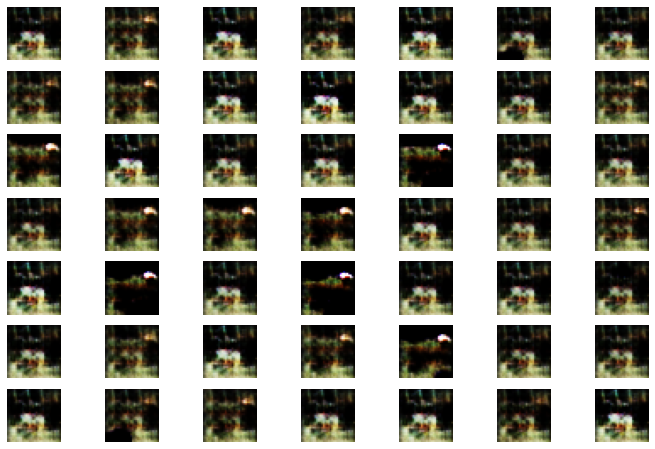

Epoch 131 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.03286590799689293 >> D_loss_2 = 0.003754157107323408 >> g_loss = 0.6051505208015442
Epoch 131 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0333738811314106 >> D_loss_2 = 0.019684938713908195 >> g_loss = 0.5150650143623352
Epoch 131 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 0.00032785386429168284 >> D_loss_2 = 0.004696359392255545 >> g_loss = 1.0559613704681396
Epoch 131 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.003674906212836504 >> D_loss_2 = 0.01621336117386818 >> g_loss = 1.5918128490447998
Epoch 131 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 0.00044935461482964456 >> D_loss_2 = 0.005953013896942139 >> g_loss = 0.20913882553577423
Epoch 131 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.02973456121981144 >> D_loss_2 = 0.007492028176784515 >> g_loss = 0.08304321765899658
Epoch 131 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 4.01386569137685e-06 >> D_loss_2 = 0.01764627918601036 >> g_loss = 

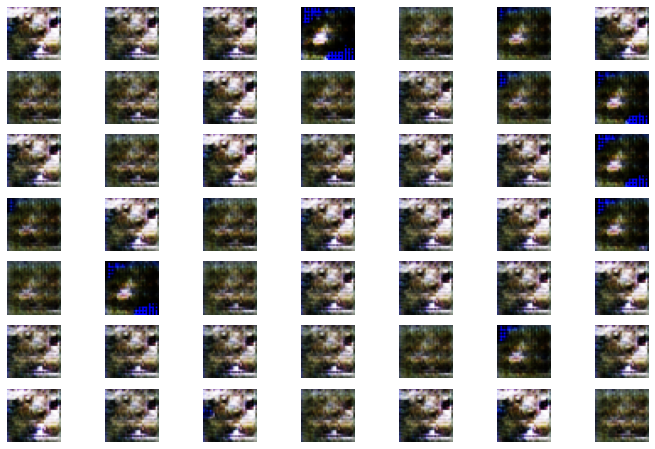

Epoch 141 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.015679549425840378 >> D_loss_2 = 0.006206810008734465 >> g_loss = 4.938587188720703
Epoch 141 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.11737347394227982 >> D_loss_2 = 0.01629994437098503 >> g_loss = 0.9182798862457275
Epoch 141 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 0.035346146672964096 >> D_loss_2 = 0.017682615667581558 >> g_loss = 4.687294960021973
Epoch 141 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.1382168084383011 >> D_loss_2 = 0.009801074862480164 >> g_loss = 1.561460256576538
Epoch 141 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 0.05382998287677765 >> D_loss_2 = 0.0592237189412117 >> g_loss = 1.835756778717041
Epoch 141 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.008617565967142582 >> D_loss_2 = 0.005013966932892799 >> g_loss = 0.7065901756286621
Epoch 141 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 0.007612618617713451 >> D_loss_2 = 0.015516720712184906 >> g_loss = 1.955313444

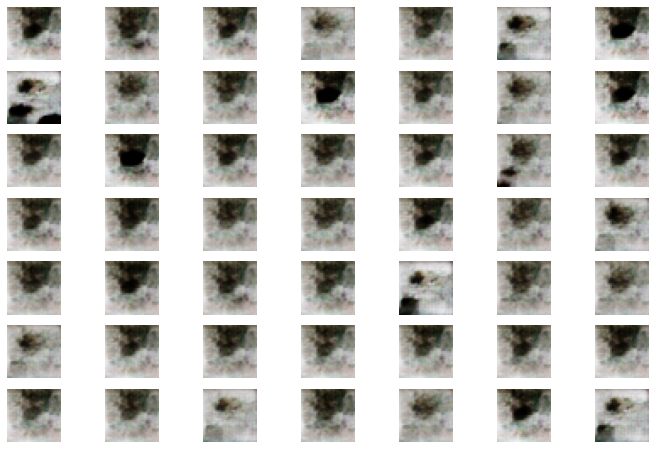

Epoch 151 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.005318121984601021 >> D_loss_2 = 0.00369799486361444 >> g_loss = 1.0908451080322266
Epoch 151 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0036852627526968718 >> D_loss_2 = 0.02007902041077614 >> g_loss = 0.14205098152160645
Epoch 151 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 0.13326731324195862 >> D_loss_2 = 0.004856421612203121 >> g_loss = 0.01698054000735283
Epoch 151 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0006254105246625841 >> D_loss_2 = 0.0035210009664297104 >> g_loss = 0.0030621071346104145
Epoch 151 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0010921345092356205 >> D_loss_2 = 0.004031404387205839 >> g_loss = 0.017434556037187576
Epoch 151 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 3.422578811645508 >> D_loss_2 = 0.0008046478033065796 >> g_loss = 10.622720718383789
Epoch 151 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 0.15650595724582672 >> D_loss_2 = 0.034630291163921356 >> g_lo

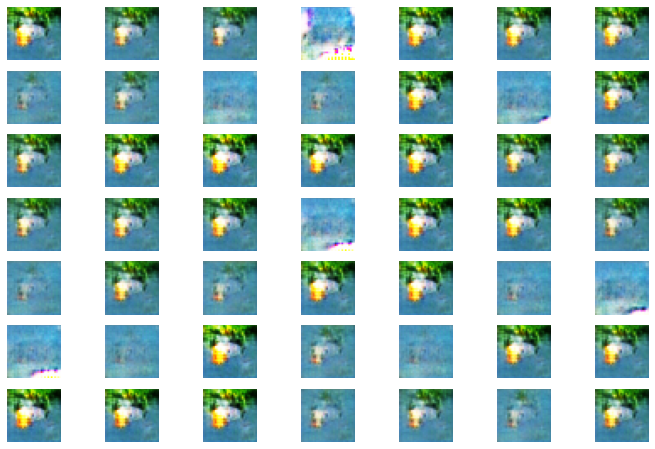

Epoch 161 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.01021894533187151 >> D_loss_2 = 0.005531942937523127 >> g_loss = 0.023129111155867577
Epoch 161 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.01799183338880539 >> D_loss_2 = 0.008371099829673767 >> g_loss = 0.017504749819636345
Epoch 161 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0036158959846943617 >> D_loss_2 = 0.0038245252799242735 >> g_loss = 0.038022205233573914
Epoch 161 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0030837792437523603 >> D_loss_2 = 0.0008486569859087467 >> g_loss = 0.07877138257026672
Epoch 161 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 2.1762074538855813e-05 >> D_loss_2 = 0.004205513745546341 >> g_loss = 0.10864803940057755
Epoch 161 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.06629683077335358 >> D_loss_2 = 0.005064652767032385 >> g_loss = 0.043532952666282654
Epoch 161 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 0.11044925451278687 >> D_loss_2 = 0.021664008498191833 

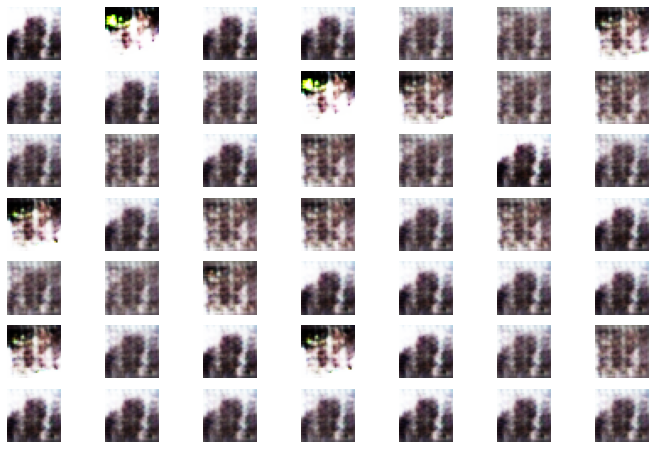

Epoch 171 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.015269245021045208 >> D_loss_2 = 0.011664729565382004 >> g_loss = 0.03451930359005928
Epoch 171 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.000650548143312335 >> D_loss_2 = 0.04657408595085144 >> g_loss = 0.7147394418716431
Epoch 171 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 0.01783127151429653 >> D_loss_2 = 0.002951123286038637 >> g_loss = 2.1749444007873535
Epoch 171 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.014559748582541943 >> D_loss_2 = 0.005750465206801891 >> g_loss = 0.08026713132858276
Epoch 171 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 5.432485068013193e-06 >> D_loss_2 = 0.0005222806939855218 >> g_loss = 0.04048933461308479
Epoch 171 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.00027260047500021756 >> D_loss_2 = 0.010099946521222591 >> g_loss = 0.0006218803464435041
Epoch 171 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 2.9876425742259016e-06 >> D_loss_2 = 0.004660295322537422 >>

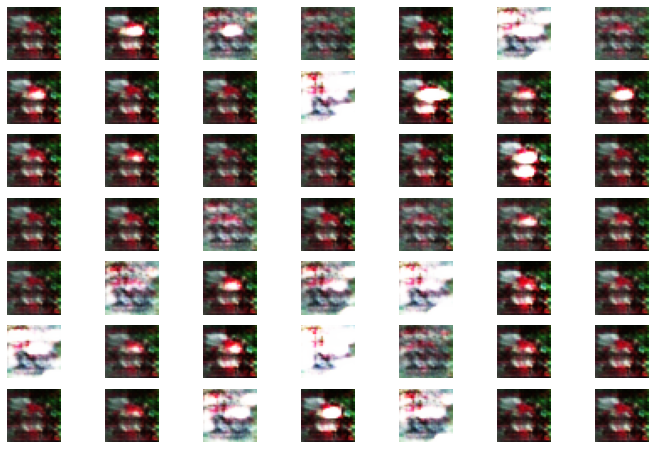

Epoch 181 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.06774743646383286 >> D_loss_2 = 0.055474307388067245 >> g_loss = 2.932929039001465
Epoch 181 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.02714432403445244 >> D_loss_2 = 0.015595892444252968 >> g_loss = 0.12525629997253418
Epoch 181 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0014711844269186258 >> D_loss_2 = 0.008762151934206486 >> g_loss = 0.5808897018432617
Epoch 181 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 0.07379098981618881 >> D_loss_2 = 0.02901170216500759 >> g_loss = 1.483567476272583
Epoch 181 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 0.01642009988427162 >> D_loss_2 = 0.006277625449001789 >> g_loss = 0.42397835850715637
Epoch 181 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0018597107846289873 >> D_loss_2 = 0.017526421695947647 >> g_loss = 0.226034015417099
Epoch 181 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 0.14164555072784424 >> D_loss_2 = 0.0008993339142762125 >> g_loss = 0.20

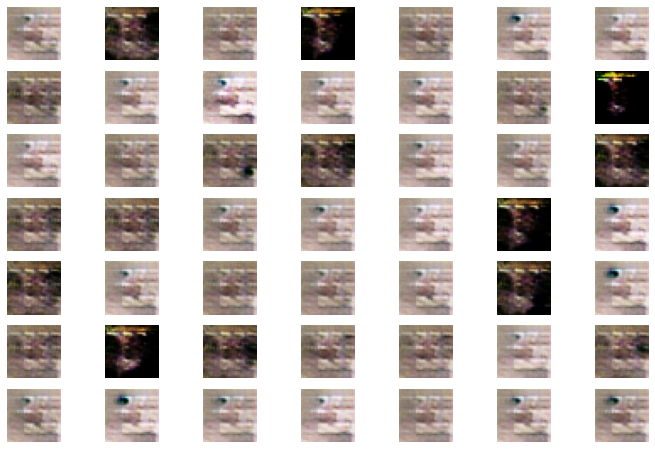

Epoch 191 >> Batch1 >> Batch_per_epoch 390 >> D_Loss_1 = 0.06239686161279678 >> D_loss_2 = 0.06622648239135742 >> g_loss = 1.7968111038208008
Epoch 191 >> Batch51 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0005209578084759414 >> D_loss_2 = 0.01304322574287653 >> g_loss = 0.36622145771980286
Epoch 191 >> Batch101 >> Batch_per_epoch 390 >> D_Loss_1 = 4.987625743524404e-06 >> D_loss_2 = 0.002538769505918026 >> g_loss = 0.06135287880897522
Epoch 191 >> Batch151 >> Batch_per_epoch 390 >> D_Loss_1 = 8.636022539576516e-05 >> D_loss_2 = 0.0007990248268470168 >> g_loss = 0.054664336144924164
Epoch 191 >> Batch201 >> Batch_per_epoch 390 >> D_Loss_1 = 2.1398032004071865e-06 >> D_loss_2 = 0.0002349793940084055 >> g_loss = 0.13022258877754211
Epoch 191 >> Batch251 >> Batch_per_epoch 390 >> D_Loss_1 = 0.0006169414846226573 >> D_loss_2 = 0.0007101492956280708 >> g_loss = 0.1525372415781021
Epoch 191 >> Batch301 >> Batch_per_epoch 390 >> D_Loss_1 = 8.072842319961637e-06 >> D_loss_2 = 0.0008456410723738372

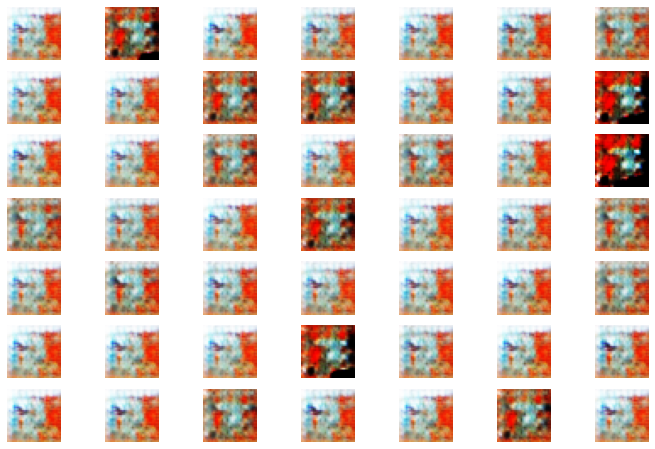

In [73]:

train(g_model, d_model, dataset, gan_model, 100)